## Week 11-12 Visual odometry

Visual odometry/ motion estimation from cameras, using the 2D-3D algorithm. Will estimate E-matrices, triangulate 3D landmarks and use PnP to fix poses to positions.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2

In [15]:
#Load the camera matrix
K = np.loadtxt('Glyp/K.txt')
K

array([[3.1174740e+03, 0.0000000e+00, 1.5019408e+03],
       [0.0000000e+00, 3.1174740e+03, 9.8476840e+02],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])

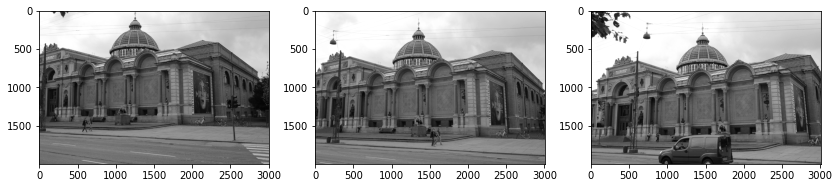

In [16]:
# Load images
ext = ['png', 'jpg', 'gif'] # filetypes
imdir = "Glyp/sequence/"
files = []
[files.extend(glob.glob(imdir + '*.' + e)) for e in ext]
images = [cv2.cvtColor(cv2.imread(file), cv2.COLOR_RGB2GRAY) for file in files]

# Look at some images
im0, im1, im2 = images[0], images[1], images[2]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs[0].imshow(im0, cmap="gray")
axs[1].imshow(im1, cmap="gray")
axs[2].imshow(im2, cmap="gray");

#### Exercise 11.1 SIFT features and matching

Find SIFT keypoints (kp0, kp1, kp2) in all three images and compute their corresponding descriptors (des0, des1, des2).\
(For speed reasons, you can limit the number of SIFT features to 2000.)

Convert the features to numpy arrays of 2D points\
```kp = np.array([k.pt for k in kp])```

Match the SIFT features between im0 and im1 (matches01), and between im1 and im2 (matches12).\
Convert the matches to numpy arrays of the indices\
```matches = np.array([(m.queryIdx, m.trainIdx) for m in matches]).```

In [144]:
def filter_points(Q, tx=100, ty=100, tz=100):
    Q = Q[:, np.abs(Q[0, :]) < tx]
    Q = Q[:, np.abs(Q[1, :]) < ty]
    Q = Q[:, np.abs(Q[2, :]) < tz]
    return Q
    
def get_all_sift(gray, nfeatures=1999):
    """
    Get stuff
    """
    sift = cv2.SIFT_create(nfeatures=nfeatures) 
                                
    kp, desc = sift.detectAndCompute(gray, None) #Keypoints and descriptors

    point = np.array([k.pt for k in kp]).astype(np.int32)
    
    return point, kp, desc

def match_sift(des1, des2, KNN_matcher=False):
    """
    Match stuff
    """
    bf = cv2.BFMatcher() #crossCheck=True
    if KNN_matcher:
        knn_matches = bf.knnMatch(des1, des2, k=2)
        # Ratio test!
        ratio_matches = []
        for m,n in knn_matches:
            if m.distance < 0.75*n.distance:
                ratio_matches.append(m)
        
        # Return the keypoint indexes of matches 
        return np.array([(m.queryIdx, m.trainIdx) for m in ratio_matches])
    else:
        all_matches = bf.match(des1, des2)
        #sorted_matches = sorted(matches, key = lambda x:x.distance)
        return np.array([(m.queryIdx, m.trainIdx) for m in all_matches])
    

In [18]:
point0, kp0, des0 = get_all_sift(im0)
point1, kp1, des1 = get_all_sift(im1)
point2, kp2, des2 = get_all_sift(im2)
point0.shape, point1.shape, point2.shape

((1999, 2), (1999, 2), (1999, 2))

In [19]:
matches01 = match_sift(des0, des1) #, KNN_matcher=True) 
matches12 = match_sift(des1, des2) #, KNN_matcher=True) 
matches01.shape, matches12.shape

((1999, 2), (1999, 2))

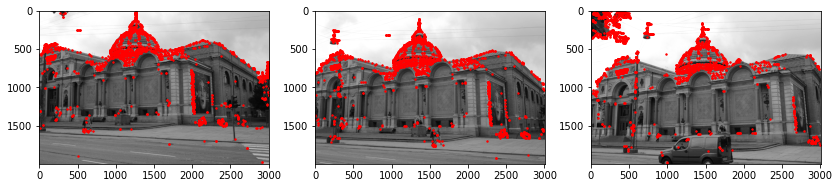

In [20]:
## Look at some images
im0, im1, im2 = images[0], images[1], images[2]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(14, 4))
axs[0].imshow(im0, cmap="gray")
axs[0].scatter(point0[:, 0], point0[:, 1], s=2, c="r")
axs[1].imshow(im1, cmap="gray")
axs[1].scatter(point1[:, 0], point1[:, 1], s=2, c="r")
axs[2].imshow(im2, cmap="gray")
axs[2].scatter(point2[:, 0], point2[:, 1], s=2, c="r");

#### EX 11.2 Essential matrix

Estimate the essential matrix between im0 and im1 with RANSAC. You can use the OpenCV \
function cv2.findEssentialMat to do this.

***NB*** The function expects the points in the correct/ matching order.

In [21]:
E01, Emask01 = cv2.findEssentialMat(point0[matches01[:, 0], :], point1[matches01[:, 1], :], K, method=cv2.RANSAC,
                           #prob=0.999, threshold=..., maxIters=...
                           )
E12, Emask12 = cv2.findEssentialMat(point1[matches12[:, 0], :], point2[matches12[:, 1], :], K, method=cv2.RANSAC,
                           #prob=0.999, threshold=..., maxIters=...
                           )
len(np.where(Emask01>0)[0])

563


Decompose the essential matrix and find the correct relative pose (R1, t1). For this we can again \
use an OpenCV function namely cv2.recoverPose.
- Choose the best of the 4 different options: The one where points are in front of cameras


In [22]:

_, R01, t01, mask01 = cv2.recoverPose(E01, point0[matches01[:, 0], :], point1[matches01[:, 1], :], K)
_, R12, t12, mask12 = cv2.recoverPose(E12, point1[matches12[:, 0], :], point2[matches12[:, 1], :], K)

len(np.where(mask01>0)[0])

1418


The mask returned by cv2.recoverPose indicates which of the matches/**POINTS** are inliers, that lie in front \
of both cameras. Remove the matches that are not inliers from matches01, so that only contains \
the inliers.


In [23]:
#matches01_filtered = matches01.copy()
#matches12_filtered = matches12.copy()
matches01_filtered = matches01[np.where(Emask01>0)[0]]
matches12_filtered = matches12[np.where(Emask12>0)[0]]
len(matches01), len(matches01_filtered)

(1999, 563)

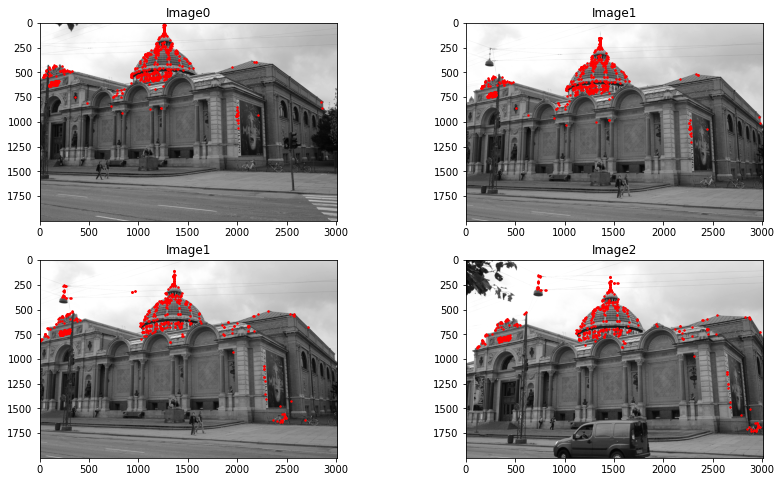

In [24]:
######################################################################################
## Let's test the filtered matches, by looking at the filtered points on the images ##
######################################################################################

im0, im1, im2 = images[0], images[1], images[2]
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
axs[0, 0].imshow(im0, cmap="gray")
axs[0, 0].scatter(point0[matches01_filtered[:, 0], 0], point0[matches01_filtered[:, 0], 1], s=2, c="r")
axs[0, 0].set_title("Image0")
axs[0, 1].imshow(im1, cmap="gray")
axs[0, 1].scatter(point1[matches01_filtered[:, 1], 0], point1[matches01_filtered[:, 1], 1], s=2, c="r")
axs[0, 1].set_title("Image1")
axs[1, 0].imshow(im1, cmap="gray")
axs[1, 0].scatter(point1[matches12_filtered[:, 0], 0], point1[matches12_filtered[:, 0], 1], s=2, c="r")
axs[1, 0].set_title("Image1")
axs[1, 1].imshow(im2, cmap="gray")
axs[1, 1].scatter(point2[matches12_filtered[:, 1], 0], point2[matches12_filtered[:, 1], 1], s=2, c="r")
axs[1, 1].set_title("Image2");

***NB!*** Using KNN ratio test to filter matches produced better results than using the recoverPose output. BUT! Fewer points - and we are doing RANSAC, so more is merrier.

#### 11.3 Track across all images

Use matches01 and matches12 and find the subset of matches such that we can match features \
all the way from image 0 to image 2. In other words, create three lists such that points0[i], \
points1[i], and points2[i] are the 2D locations of the same point in the corresponding images.

In [25]:
#Find the intersection of two arrays.
# So, in this case where will matches between two first images, continue into the third
_, idx01, idx12 = np.intersect1d(matches01_filtered[:,1], matches12_filtered[:,0], return_indices=True)

#Return the sorted, unique values that are in both of the input arrays.
# So, idx01: indexes of matches in matches01_filtered that were also matches in image 2.as_integer_ratio
# And idx12 is also the valid matches in matches12_filtered 

***Question*** In the exercise it was only explained to filter matches 01, not matches 12.

In [26]:
# Extracting the valid matches - that go throughout the images
validmatch01 = matches01_filtered[idx01, :]
validmatch12 = matches12_filtered[idx12, :]

# Extract the points belonging to the valid matches
val0_idx = validmatch01[:, 0]
val1_idx = validmatch01[:, 1]
val2_idx = validmatch12[:, 1]

trans0 = point0[val0_idx, :].astype(np.float32)
trans1 = point1[val1_idx, :].astype(np.float32)
trans2 = point2[val2_idx, :].astype(np.float32)

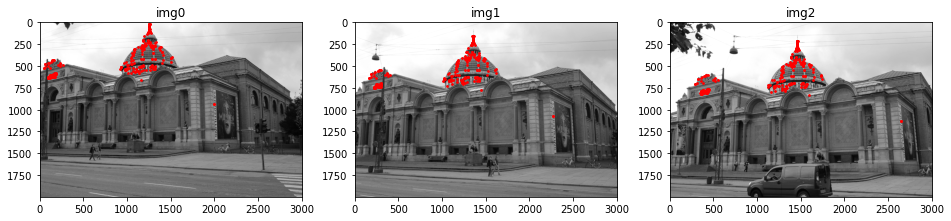

In [27]:
# Look at some images
im0, im1, im2 = images[0], images[1], images[2]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 16))
axs[0].imshow(im0, cmap="gray")
axs[0].scatter(trans0[:, 0], trans0[:, 1], s=3, c="r")
axs[0].set_title("img0")
axs[1].imshow(im1, cmap="gray")
axs[1].scatter(trans1[:, 0], trans1[:, 1], s=3, c="r")
axs[1].set_title("img1")
axs[2].imshow(im2, cmap="gray")
axs[2].scatter(trans2[:, 0], trans2[:, 1], s=3, c="r")
axs[2].set_title("img2");

#### 11.4 Triangulate

For the points that have been tracked through all three images, use the 2D positions in image 0\
and 1 to triangulate the points in 3D (Q). Using the 2D positions in image 2, estimate the pose\
of image 2 with RANSAC. Use cv2.solvePnPRansac to do this. As the lens distortion is already\
corrected, you can set ```distCoeffs=np.zeros(5)```.

Visualize the 3D points that are also inliers for solvePnPRansac.
```
fig = plt.figure()
ax = fig.add_subplot(projection=’3d’)
ax.scatter(*Q[inliers.flatten()])
```
Also plot the position of the cameras. Recall that the position of the camera is not the translation.
How do you find the position?


In [28]:
distCoeffs=np.zeros(5) 
# Projection matrix using 
P0 = K@np.hstack((np.eye(3), np.zeros((3,1))))
P1 = K@np.hstack((R01, t01))

In [32]:
Q = cv2.triangulatePoints(P0, P1, trans0.T, trans1.T)
Q = Q[:-1] / Q[-1]
Q.shape

(3, 232)

In [35]:
# Get rvec, tvec of the image 2
_, rvec, tvec, inliers = cv2.solvePnPRansac(Q.T, trans2, K, None)
rot, _ = cv2.Rodrigues(rvec)
tvec = -rot.T.dot(tvec)  # coordinate transformation, from camera to world.

In [41]:
Q.shape, inliers.shape

((3, 232), (205, 1))

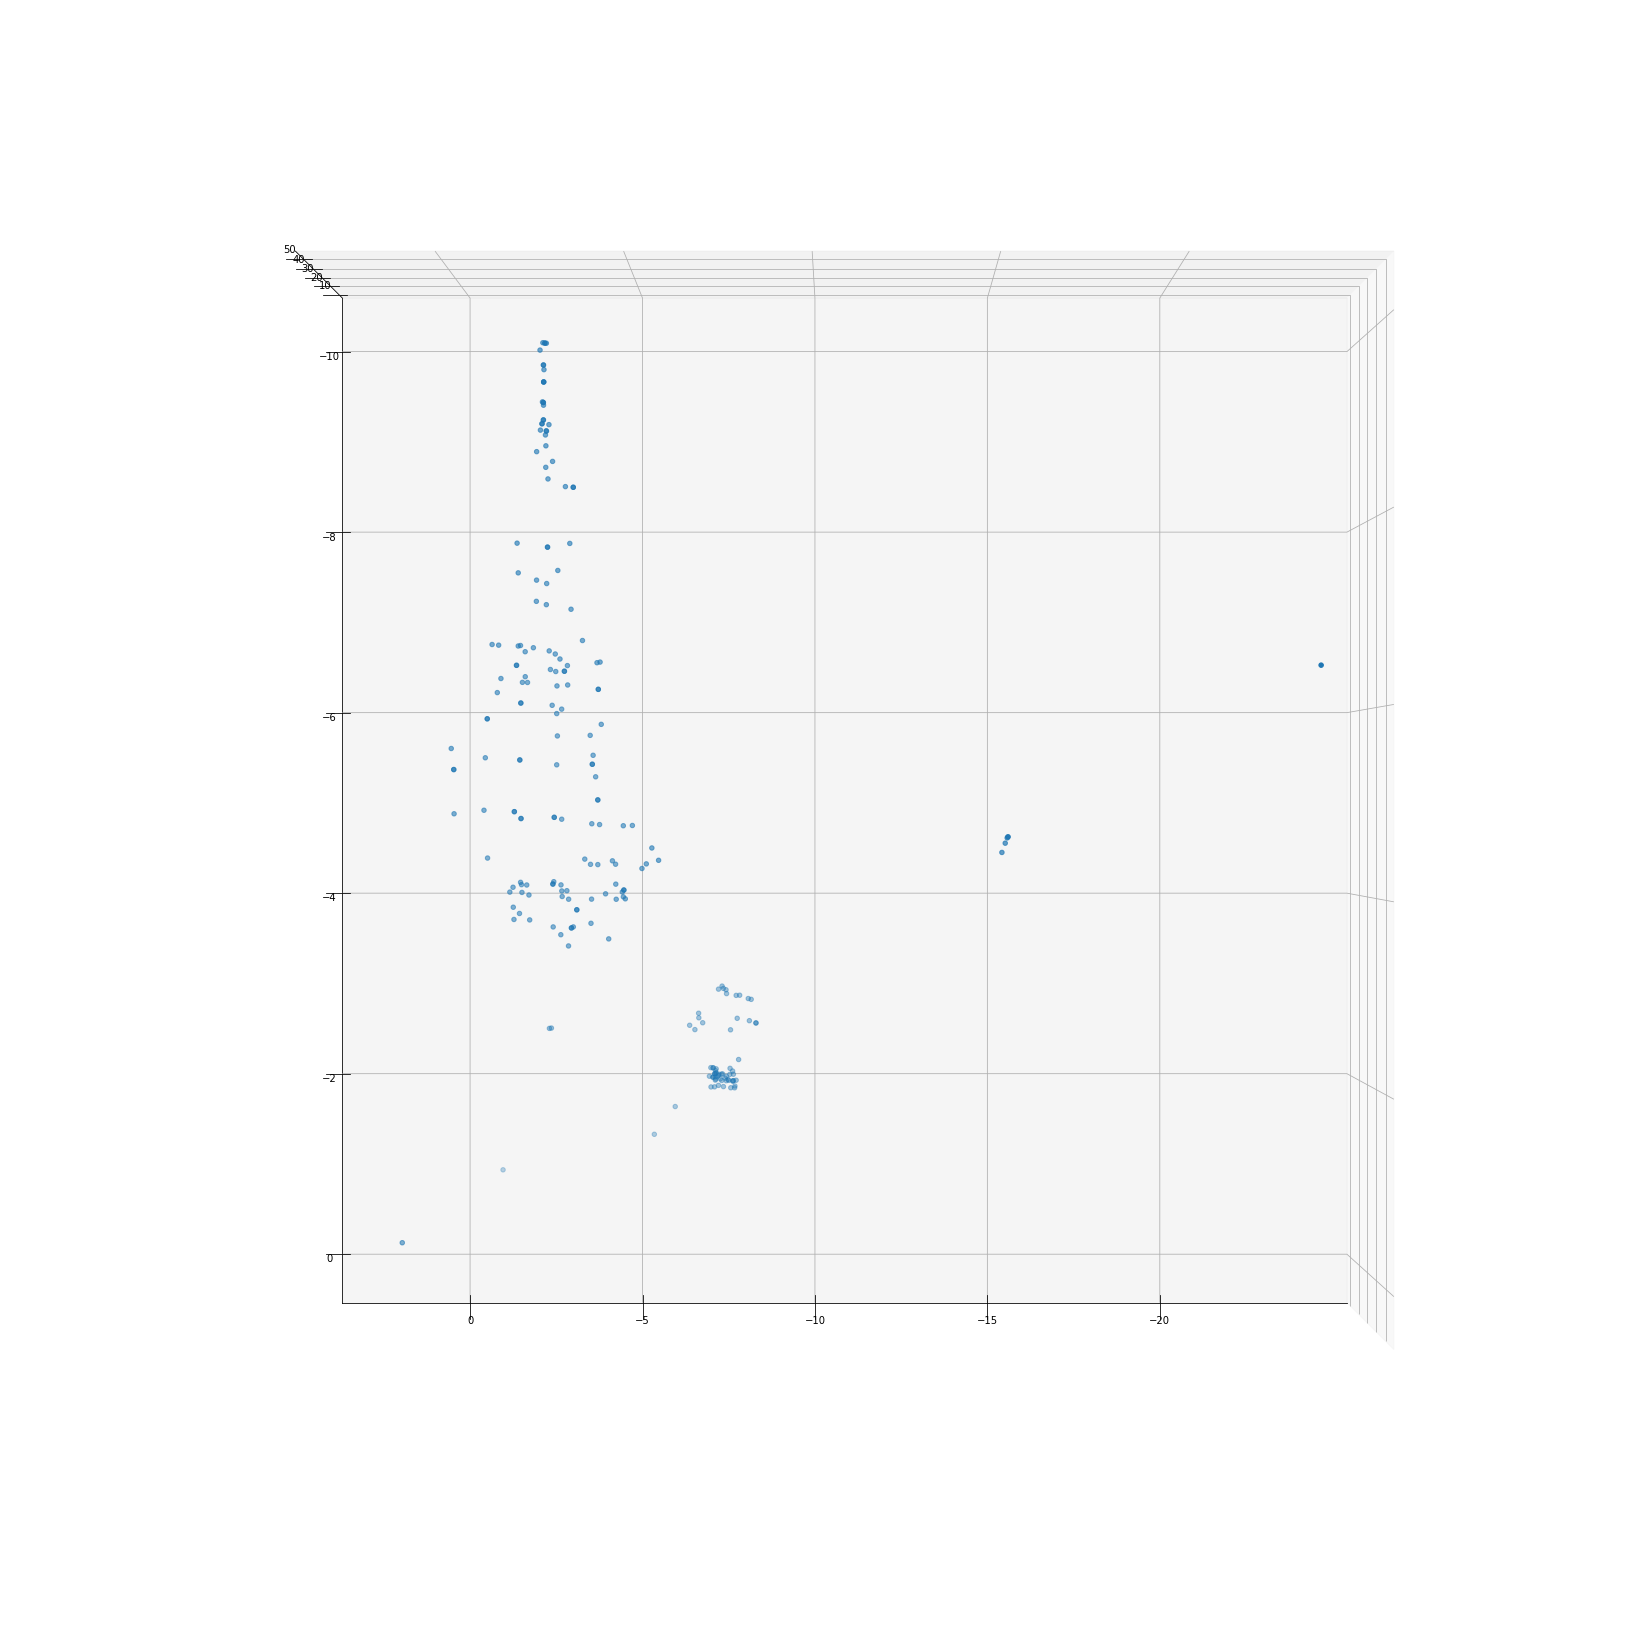

In [112]:
# Visualize 3D points that are also inliers for solveRansac
#fig = plt.figure()
#ax = fig.add_subplot(projection="3d")
#ax.scatter(Q[0, inliers], Q[1, inliers], Q[2, inliers]);

Q_filter = filter_points(Q)

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_filter[0, :], Q_filter[1, :], Q_filter[2, :]);
ax.view_init(90, 90);

**NB** These points that was also an inlier for the PnP can be kept as landmark points for the next generation, instead of calculating all new ones.

### 11.5 Putting it al together

In [70]:
from tqdm import tqdm

In [164]:
##########################
### FIRST THREE IMAGES ###
##########################

# Extract keypoints
point0, kp0, des0 = get_all_sift(images[0])
point1, kp1, des1 = get_all_sift(images[1])
point2, kp2, des2 = get_all_sift(images[2])
# Match keypoints
matches01 = match_sift(des0, des1) #, KNN_matcher=True) 
matches12 = match_sift(des1, des2) #, KNN_matcher=True) 
matches01.shape, matches12.shape

# Recover essential matries
E01, Emask01 = cv2.findEssentialMat(point0[matches01[:, 0], :], point1[matches01[:, 1], :], K, method=cv2.RANSAC,
                        #prob=0.999, threshold=..., maxIters=...
                        )
E12, Emask12 = cv2.findEssentialMat(point1[matches12[:, 0], :], point2[matches12[:, 1], :], K, method=cv2.RANSAC,
                        #prob=0.999, threshold=..., maxIters=...
                        )

# Recover camera poses
_, R01, t01, _ = cv2.recoverPose(E01, point0[matches01[:, 0], :], point1[matches01[:, 1], :], K)
#_, R12, t12, _ = cv2.recoverPose(E12, point1[matches12[:, 0], :], point2[matches12[:, 1], :], K)

# Filter matches based on inliers
matches01_filtered = matches01[np.where(Emask01>0)[0]]
matches12_filtered = matches12[np.where(Emask12>0)[0]]

# Intersection of matches
_, idx01, idx12 = np.intersect1d(matches01_filtered[:,1], matches12_filtered[:,0], return_indices=True)

# Extracting the valid matches - that go throughout the images
validmatch01 = matches01_filtered[idx01, :]
validmatch12 = matches12_filtered[idx12, :]

# Extract the points belonging to the valid matches
val0_idx = validmatch01[:, 0]
val1_idx = validmatch01[:, 1]
val2_idx = validmatch12[:, 1]

#
trans0 = point0[val0_idx, :].astype(np.float32)
trans1 = point1[val1_idx, :].astype(np.float32)
trans2 = point2[val2_idx, :].astype(np.float32)
valid_des_2 = des2[val2_idx, :]

# Projection matrix using 
P0 = K@np.hstack((np.eye(3), np.zeros((3,1))))
P1 = K@np.hstack((R01, t01))
#P2 = K@np.hstack((R12, t12)) # !!!???

# Triangulate points to world coordinates
Q = cv2.triangulatePoints(P0, P1, trans0.T, trans1.T)
Q = Q[:-1] / Q[-1]

# PnP to get position of object
_, rvec, tvec, inliers = cv2.solvePnPRansac(Q.T, trans2, K, None)
rot, _ = cv2.Rodrigues(rvec)
#tvec = -rot.T.dot(tvec)
P2 = K@np.hstack((rot, tvec))

print(inliers.shape, Q.T.shape, trans2.shape, valid_des_2.shape)

(205, 1) (232, 3) (232, 2) (232, 128)


In [169]:
##############################
### The rest of the images ###
##############################
prev_des = valid_des_2.copy()           # Only keep valid
prev_points = trans2.copy()             # Only keep valid
#prev_des = des2                        # Keep all descriptors
#prev_points = point2                   # keep all points    
P_prev = P2.copy()                      # World-coordinate pose: TODO: maybe we need pose not pos?
Q_prev = Q.copy()                       # Landmarks
#######  Book-keeping ########
all_Qs = [Q]
all_ts = [tvec]
all_Rs = [rot]

for i in tqdm(range(3, len(images))):
#for i in range(3, len(images)):
    """
    Loopy doopy.
    """
    current_frame = images[i]
    # Extract keypoints
    new_points, new_kp, new_des = get_all_sift(current_frame)
    
    # Match keypoints
    matches = match_sift(prev_des, new_des)

    # Recover essential matries - ONLY FOR FILTERING INLIERS.
    _, Emask = cv2.findEssentialMat(prev_points[matches[:, 0], :], new_points[matches[:, 1], :], K, method=cv2.RANSAC)
    
    # Recover relative pose - NO! Do this by PnP
    #_, R_new, t_new, _ = cv2.recoverPose(E, prev_points[matches[:, 0], :], new_points[matches[:, 1], :], K)
    #P_new = K@np.hstack((R_new, t_new))

    # Filter matches based on inliers
    matches_filtered = matches[np.where(Emask>0)[0]]
    
    # Extract the points belonging to the valid matches!
    prev_idx = matches_filtered[:, 0]
    new_idx = matches_filtered[:, 1]

    # Extract "transitive" points and cast to float.
    prev_trans = prev_points[prev_idx, :].astype(np.float32)
    Q_prev_trans = Q_prev[:, prev_idx] # Also remove Qs not found
    valid_des = new_des[new_idx, :]
    new_trans = new_points[new_idx, :].astype(np.float32)

    # PnP to get position
    # TODO: ...
    _, rvec, tvec, inliers = cv2.solvePnPRansac(Q_prev_trans.T, new_trans, K, None)
    rot, _ = cv2.Rodrigues(rvec)
    #tvec = -rot.T.dot(tvec)
    P_new = K@np.hstack((rot, tvec))

    # Projection matrix using 
    Q_new = cv2.triangulatePoints(P_prev, P_new, prev_trans.T, new_trans.T)
    #Q_new = cv2.triangulatePoints(P_prev, P_new, prev_trans.T, new_trans.T)
    Q_new = Q_new[:-1] / Q_new[-1]

    ############################################################
    ####################### Book-keeping #######################
    ############################################################
    all_Qs.append(Q_new)
    all_ts.append(tvec)
    all_Rs.append(rot)
    #
    prev_des = valid_des.copy()        # Only valid
    prev_points = new_trans.copy()     # Only valid
    P_prev = P_new.copy()              # World-coordinate pose
    Q_prev = Q_new.copy()              # Landmarks
    #



100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


In [170]:
for i in range(len(all_Qs)):
    print(all_Qs[i].shape)

(3, 232)
(3, 147)
(3, 90)
(3, 65)
(3, 47)
(3, 36)
(3, 26)
(3, 21)
(3, 20)
(3, 16)
(3, 15)
(3, 13)
(3, 9)
(3, 7)
(3, 7)
(3, 7)
(3, 7)
(3, 7)


In [172]:
for i in range(len(all_ts)):
    print(all_ts[i])

[[  9.2982749 ]
 [ -9.48830711]
 [-14.26501332]]
[[ 3.25813801]
 [-0.23220201]
 [-2.25387805]]
[[ 4.32000443]
 [-0.13503217]
 [-2.88852633]]
[[ 5.14426914]
 [-0.28214049]
 [-3.50877639]]
[[ 7.31242642]
 [-0.43939018]
 [-2.91948082]]
[[ 8.54189269]
 [-0.14923356]
 [-2.20057499]]
[[10.85251077]
 [ 0.36981234]
 [-0.32538604]]
[[13.14061388]
 [ 0.94124354]
 [ 2.74504457]]
[[14.52583298]
 [ 0.29185473]
 [ 1.6609849 ]]
[[-25.92586742]
 [ 11.91701672]
 [-38.6463543 ]]
[[20.92788198]
 [-2.66186803]
 [18.93549375]]
[[25.32698506]
 [-6.19726507]
 [23.87416227]]
[[ 5.63811963]
 [ 5.99543092]
 [16.39860138]]
[[ 10.11110424]
 [  0.38485476]
 [-12.82801737]]
[[  7.84903417]
 [  1.94591088]
 [-15.53313498]]
[[-13.36072946]
 [ -4.36323874]
 [-10.71881875]]
[[ -4.47375871]
 [  4.95852656]
 [-18.48911376]]
[[  9.2982749 ]
 [ -9.48830711]
 [-14.26501332]]


(3, 772)
(3, 770)


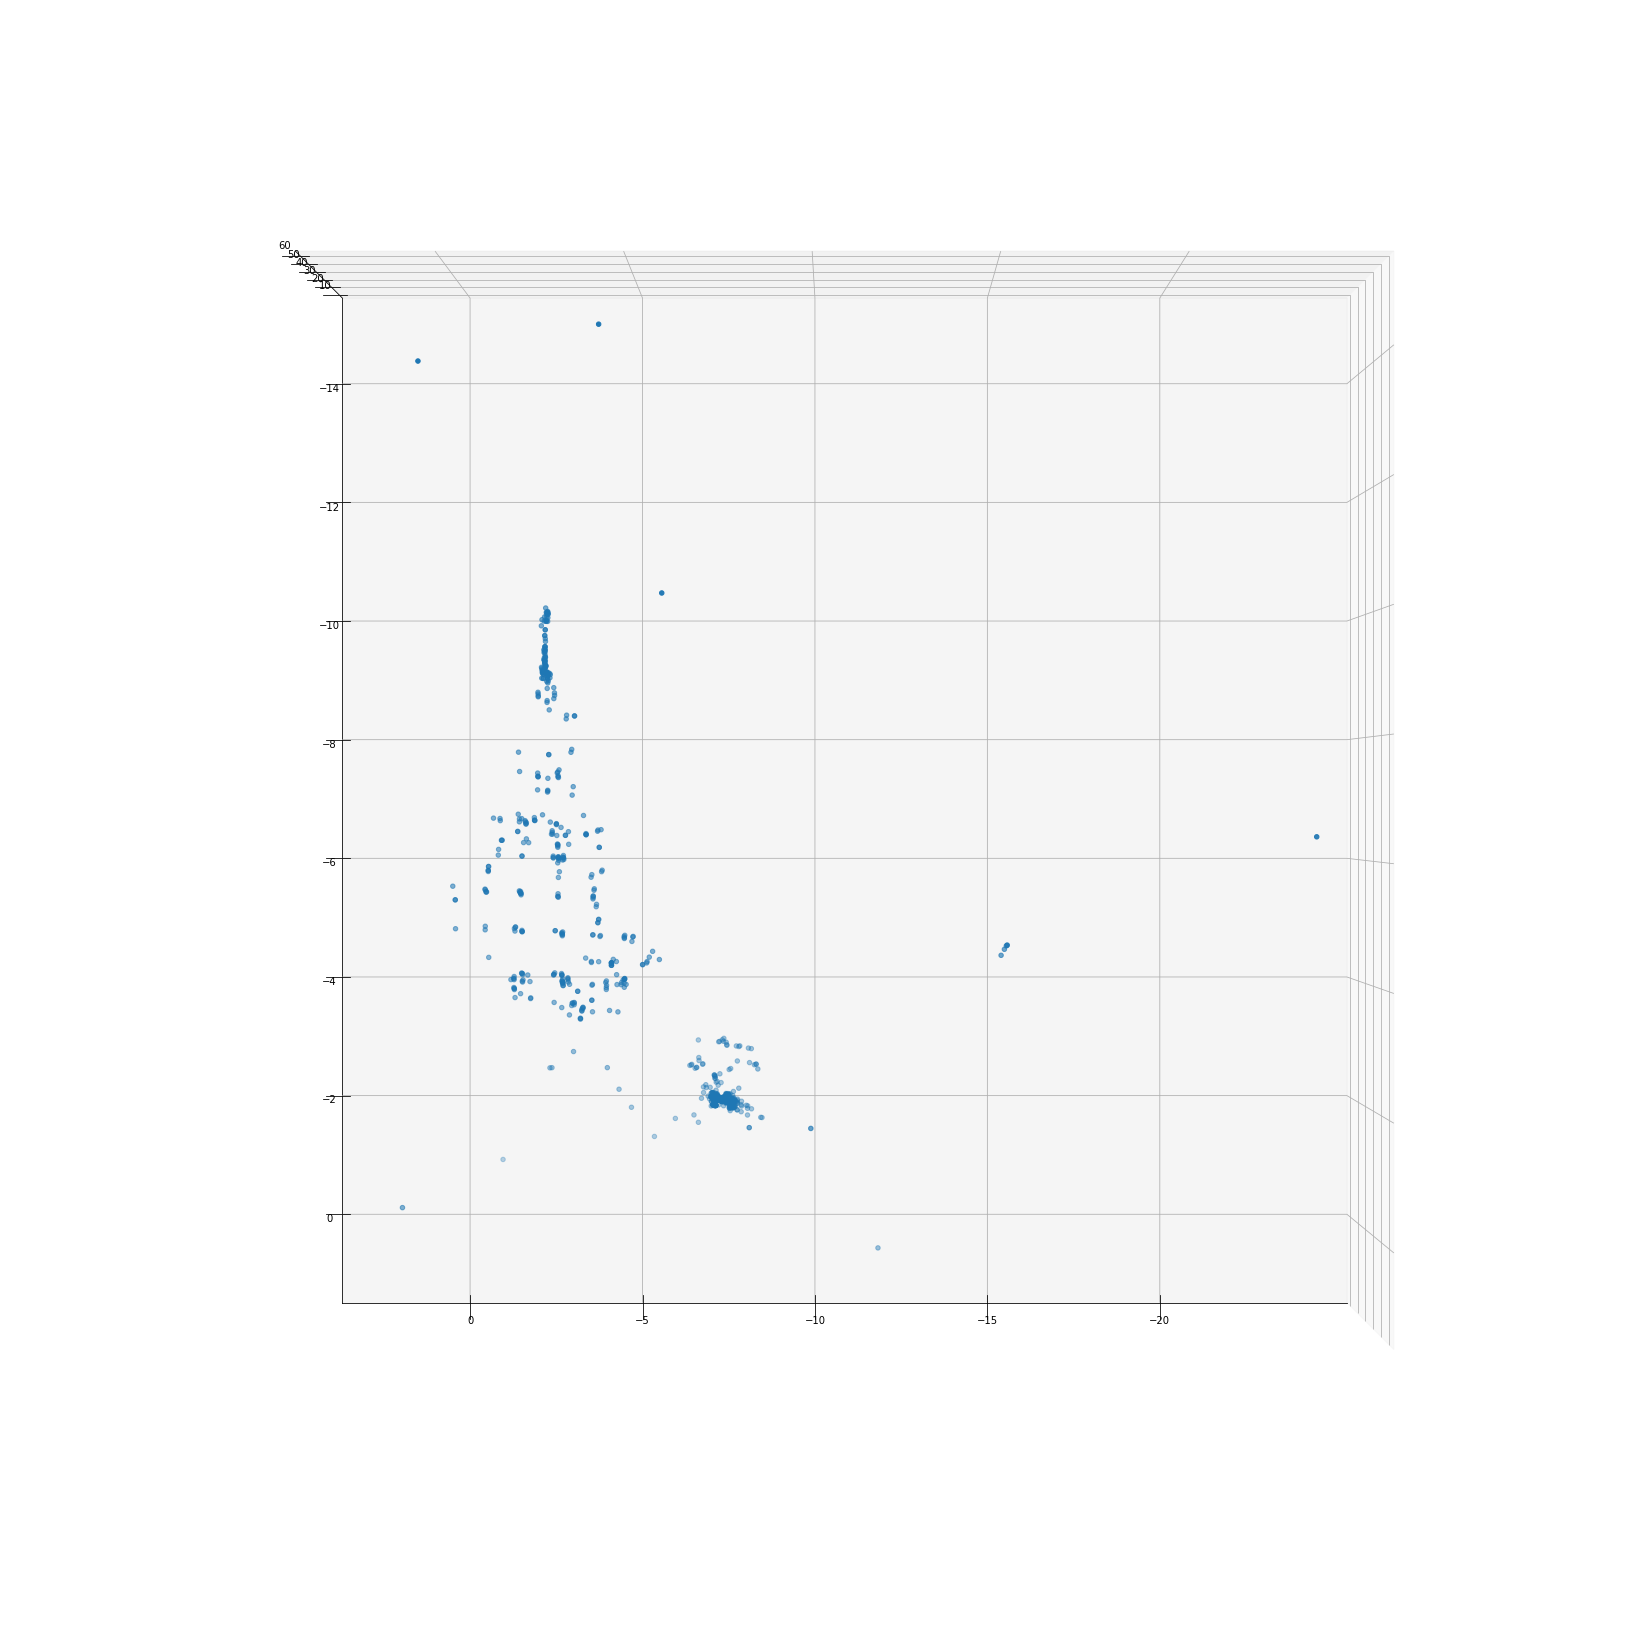

In [171]:
Qs = np.hstack(all_Qs)
print(Qs.shape)
Q_filter = filter_points(Qs)
print(Q_filter.shape)

fig = plt.figure(figsize=(30, 30))
ax = fig.add_subplot(projection="3d")
ax.scatter(Q_filter[0, :], Q_filter[1, :], Q_filter[2, :]);
ax.view_init(90, 90);